In this note bookbook, we will make a few changes to the workflow by referring to the one of the available kernels.

Planned Changes:
- Create and save images by reading parquet
- Istead of convering grayscale into 3-channel, we will modify the architecture to accomodate 1-channel images

In [1]:
%matplotlib inline 
# If we don't do this then image will open as pop-up and not in notebook

In [2]:
import pyarrow.parquet as pq 
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib as plt
from matplotlib.pyplot import imshow

In [3]:
from skimage import io

In [4]:
import wget
import time
import os
import copy

In [5]:
!ls -l ~/datasets/bengali-ai/

total 9126408
-rw-r--r-- 1 ubuntu ubuntu 4161805187 Jan 16 23:18 bengaliai-cv19.zip
-rw-r--r-- 1 ubuntu ubuntu       4830 Dec 19 18:22 class_map.csv
-rw-r--r-- 1 ubuntu ubuntu        944 Dec 19 18:22 sample_submission.csv
-rw-r--r-- 1 ubuntu ubuntu       1742 Dec 19 18:22 test.csv
-rw-r--r-- 1 ubuntu ubuntu    9903859 Dec 19 18:22 test_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu   10003997 Dec 19 18:22 test_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu    9996850 Dec 19 18:22 test_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu    9995989 Dec 19 18:22 test_image_data_3.parquet
-rw-r--r-- 1 ubuntu ubuntu    6281787 Dec 19 18:22 train.csv
-rw-r--r-- 1 ubuntu ubuntu 1285682162 Dec 19 18:22 train_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu 1278647926 Dec 19 18:25 train_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu 1287469785 Dec 19 18:29 train_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu 1285595675 Dec 19 18:32 train_image_data_3.parquet
drwxr-xr-x 7 ubuntu ubuntu       4096

### Class Mapping File

In [6]:
class_map = pd.read_csv("/home/ubuntu/datasets/bengali-ai/class_map.csv")

In [7]:
class_map.shape

(186, 3)

In [8]:
class_map.describe

<bound method NDFrame.describe of           component_type  label component
0          grapheme_root      0         ং
1          grapheme_root      1         ঃ
2          grapheme_root      2         অ
3          grapheme_root      3         আ
4          grapheme_root      4         ই
5          grapheme_root      5         ঈ
6          grapheme_root      6         উ
7          grapheme_root      7         ঊ
8          grapheme_root      8         ঋ
9          grapheme_root      9         এ
10         grapheme_root     10         ঐ
11         grapheme_root     11         ও
12         grapheme_root     12         ঔ
13         grapheme_root     13         ক
14         grapheme_root     14       ক্ক
15         grapheme_root     15       ক্ট
16         grapheme_root     16       ক্ত
17         grapheme_root     17       ক্ল
18         grapheme_root     18       ক্ষ
19         grapheme_root     19     ক্ষ্ণ
20         grapheme_root     20     ক্ষ্ম
21         grapheme_root     21       ক্স


In [10]:
class_map.head(10)

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
5,grapheme_root,5,ঈ
6,grapheme_root,6,উ
7,grapheme_root,7,ঊ
8,grapheme_root,8,ঋ
9,grapheme_root,9,এ


### The Train Files

In [11]:
# Training label files
train_labels = pd.read_csv("/home/ubuntu/datasets/bengali-ai/train.csv")

In [12]:
train_labels.shape

(200840, 5)

In [13]:
train_labels['grapheme_root'].max(), train_labels['grapheme_root'].min(), train_labels['grapheme_root'].unique()

(167,
 0,
 array([ 15, 159,  22,  53,  71, 153,  52, 139,  67,  64, 115, 107,  74,
        100,  48,  72,  13,  79, 109,  23,  42,  60, 142,  61, 147,  81,
        148, 160,  58,  99, 103,  44, 167, 120,  62, 151,  32, 125,  38,
        127,  24, 124,  96,  43, 132, 149, 123,  54,  19,  87,  35,  83,
         97,  77, 165,  92, 133, 118,  85,  56,  95, 136, 138, 106,  86,
         29,  39, 122,  65,  30,  76,  16,  68, 110,  46, 105, 155, 129,
         25,  59,  36,  70, 152,  18,  89, 128, 113, 144,  49, 117, 154,
         31,   6,  26, 150,  40, 111,  55,   1, 119, 140,  66,  28,  14,
        164,  27, 121, 156,  63,  84, 137,  98, 143,  47, 135,  75, 141,
         88, 116,  91,  45,  69,  94,  93, 131, 146, 134, 112, 108,   9,
         80,   3, 166,  41,  17, 162,  21, 158,  10,  51, 101,  82,  57,
          4,   5,  90,  20,   2, 102, 126,  33, 161,  34,  50,   7, 163,
         78,  73, 145, 130,   0, 104,   8,  37,  11, 157, 114,  12]))

In [14]:
!ls -l /home/ubuntu/datasets/bengali-ai/

total 9126408
-rw-r--r-- 1 ubuntu ubuntu 4161805187 Jan 16 23:18 bengaliai-cv19.zip
-rw-r--r-- 1 ubuntu ubuntu       4830 Dec 19 18:22 class_map.csv
-rw-r--r-- 1 ubuntu ubuntu        944 Dec 19 18:22 sample_submission.csv
-rw-r--r-- 1 ubuntu ubuntu       1742 Dec 19 18:22 test.csv
-rw-r--r-- 1 ubuntu ubuntu    9903859 Dec 19 18:22 test_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu   10003997 Dec 19 18:22 test_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu    9996850 Dec 19 18:22 test_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu    9995989 Dec 19 18:22 test_image_data_3.parquet
-rw-r--r-- 1 ubuntu ubuntu    6281787 Dec 19 18:22 train.csv
-rw-r--r-- 1 ubuntu ubuntu 1285682162 Dec 19 18:22 train_image_data_0.parquet
-rw-r--r-- 1 ubuntu ubuntu 1278647926 Dec 19 18:25 train_image_data_1.parquet
-rw-r--r-- 1 ubuntu ubuntu 1287469785 Dec 19 18:29 train_image_data_2.parquet
-rw-r--r-- 1 ubuntu ubuntu 1285595675 Dec 19 18:32 train_image_data_3.parquet
drwxr-xr-x 7 ubuntu ubuntu       4096

### Getting the data ready

In [15]:
# PyTorch databuild libraries and modules
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

Let's write a simple function to display an image

In [16]:
from torchvision.utils import save_image

In [17]:
def show_image(dataframe, n):
    img_name = dataframe.iloc[n, 0]
    img_data = np.array(dataframe.iloc[n, 1:])
    img_data = img_data.astype('float').reshape(137,236)
    img = im.fromarray(img_data, mode='L')
    #img.save("test.png")
    #img_data = img_data.transforms.ToTensor()
    #img_data = im.fromarray(img_data, mode='L')
    #save_image(img_data,str(img_name)+'.png')
    imshow(img_data, cmap='gray')

Object `img.save("test.png")` not found.


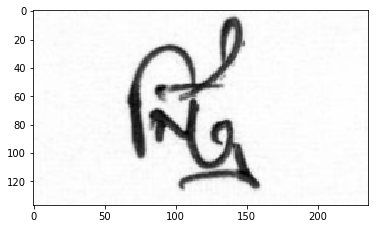

In [110]:
show_image(train, 69)

In [18]:
def show_image_resized(dataframe, n):
    img_name = dataframe.iloc[n, 0]
    img_data = np.array(dataframe.iloc[n, 1:])
    img_data = img_data.astype('float').reshape(137,236)
    #img_data = im.resize img_data
    img_data = cv2.resize(img_data, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    # normalizing the image
    img_data = (img_data*(255.0/img_data.max())).astype(np.uint8)
    # show
    imshow(img_data, cmap='gray')

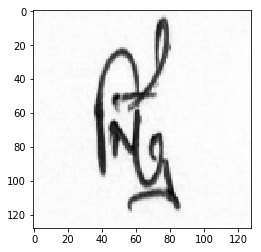

In [113]:
show_image_resized(train, 69)

In [19]:
import cv2

In [20]:
def save_image(dataframe, n):
    img_name = dataframe.iloc[n, 0]
    img_data = np.array(dataframe.iloc[n, 1:])
    img_data = img_data.astype('float').reshape(137,236)
    #img_data = im.resize img_data
    img_data = cv2.resize(img_data, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    # normalizing the image
    img_data = (img_data*(255.0/img_data.max())).astype(np.uint8)
    # save
    plt.image.imsave(img_name+'.png', img_data, cmap='gray')

Now all images are transformed and saved on the disk.

In [21]:
import torch
from torchvision import datasets, models, transforms

In [43]:
# We plan to understand the details of ResNEt18 and then change the layer conf to accept 1-channel input

In [22]:
model_resnet = models.resnet18()
# print(model_resnet)

In [23]:
class BengaliCharacterDataset(Dataset):
    """Bengali language handwritten character dataset."""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            dataframe (string): Dataframe of parquet dataset with image data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):        
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = 'Train_'+str(idx)
        img_name = image_id+'.png'
        
        # columns from class_map: image_id, grapheme_root, vowel_diacritic, consonant_diacritic, grapheme
        img_label = train_labels.loc[train_labels['image_id'] == image_id, 'grapheme_root'].to_numpy()[0] 
        # added to.numpy()[0] to remove index number
                
        img_path = os.path.join(self.root_dir,img_name)
        image = io.imread(img_path)

        # sample = {'image': img_data, 'img_label': img_label}
        
        if self.transform:
            image = self.transform(im.fromarray(image).convert('RGB'))
            # sample = {'img_label': img_label, 'image': img_data}

        return image, img_label

In [27]:
ben_char_dataset = BengaliCharacterDataset('/home/ubuntu/datasets/bengali-ai/training_images/train_224by224/')

In [28]:
ben_char_dataset.__len__()

200840

In [29]:
tt = ben_char_dataset.__getitem__(idx = 65)
type(tt),tt

(tuple, (array([[[250, 250, 250, 255],
          [252, 252, 252, 255],
          [249, 249, 249, 255],
          ...,
          [252, 252, 252, 255],
          [252, 252, 252, 255],
          [251, 251, 251, 255]],
  
         [[251, 251, 251, 255],
          [252, 252, 252, 255],
          [251, 251, 251, 255],
          ...,
          [252, 252, 252, 255],
          [251, 251, 251, 255],
          [251, 251, 251, 255]],
  
         [[253, 253, 253, 255],
          [253, 253, 253, 255],
          [253, 253, 253, 255],
          ...,
          [251, 251, 251, 255],
          [251, 251, 251, 255],
          [252, 252, 252, 255]],
  
         ...,
  
         [[251, 251, 251, 255],
          [253, 253, 253, 255],
          [253, 253, 253, 255],
          ...,
          [252, 252, 252, 255],
          [252, 252, 252, 255],
          [252, 252, 252, 255]],
  
         [[251, 251, 251, 255],
          [252, 252, 252, 255],
          [252, 252, 252, 255],
          ...,
          [251, 251, 

In [30]:
tt[1]

87

(87, <matplotlib.image.AxesImage at 0x7f94799e5cc0>)

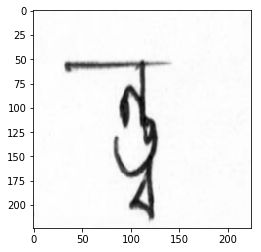

In [31]:
# We got the raw, non-transformed image with idx = 65
np_arr_img = im.fromarray(tt[0])
tt[1], imshow(np_arr_img, cmap='gray')

In [32]:
# Now let's create a PyTorch Dataset object with transformations
transformed_dataset = BengaliCharacterDataset(root_dir='/home/ubuntu/datasets/bengali-ai/training_images/train_224by224//',
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               transforms.Normalize([0.0692, 0.0692, 0.0692], [0.2051, 0.2051, 0.2051])
                                           ]))

In [33]:
tt = transformed_dataset.__getitem__(65)

In [34]:
len(tt), tt

(2, (tensor([[[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
           [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
           [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.4809],
           ...,
           [4.4618, 4.5000, 4.5000,  ..., 4.4809, 4.4809, 4.4809],
           [4.4618, 4.4809, 4.4809,  ..., 4.4618, 4.4618, 4.4809],
           [4.4618, 4.4618, 4.4809,  ..., 4.4618, 4.4618, 4.4809]],
  
          [[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
           [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
           [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.4809],
           ...,
           [4.4618, 4.5000, 4.5000,  ..., 4.4809, 4.4809, 4.4809],
           [4.4618, 4.4809, 4.4809,  ..., 4.4618, 4.4618, 4.4809],
           [4.4618, 4.4618, 4.4809,  ..., 4.4618, 4.4618, 4.4809]],
  
          [[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
           [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
           [4.5000,

In [35]:
tt[0]

tensor([[[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
         [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
         [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.4809],
         ...,
         [4.4618, 4.5000, 4.5000,  ..., 4.4809, 4.4809, 4.4809],
         [4.4618, 4.4809, 4.4809,  ..., 4.4618, 4.4618, 4.4809],
         [4.4618, 4.4618, 4.4809,  ..., 4.4618, 4.4618, 4.4809]],

        [[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
         [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
         [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.4809],
         ...,
         [4.4618, 4.5000, 4.5000,  ..., 4.4809, 4.4809, 4.4809],
         [4.4618, 4.4809, 4.4809,  ..., 4.4618, 4.4618, 4.4809],
         [4.4618, 4.4618, 4.4809,  ..., 4.4618, 4.4618, 4.4809]],

        [[4.4427, 4.4809, 4.4236,  ..., 4.4809, 4.4809, 4.4618],
         [4.4618, 4.4809, 4.4618,  ..., 4.4809, 4.4618, 4.4618],
         [4.5000, 4.5000, 4.5000,  ..., 4.4618, 4.4618, 4.

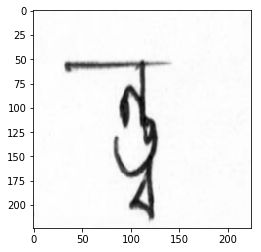

In [36]:
# to_pil = transforms.ToPILImage() 
imshow(tt[0][0], cmap='gray')

### Creating a validation dataset from training data

In [37]:
# validation_split = .2
# shuffle_dataset = True
# random_seed= 42

# # Creating data indices for training and validation splits:
# dataset_size = len(transformed_dataset)
# indices = list(range(dataset_size))

In [57]:
# # Let's make sure there are no duplicates in indices before creating a validation data based on it
# idx = range(0,len(transformed_dataset))
# len(idx), min(idx), max(idx)

In [39]:
# from torch.utils.data.sampler import SubsetRandomSampler

In [60]:
train_size = int(0.8 * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, val_size])

In [61]:
len(train_dataset), len(val_dataset)

(160672, 40168)

In [40]:
# split = int(np.floor(validation_split * dataset_size))
# # split = 40,168

# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

In [62]:
# # Let's check how it looks
# len(train_sampler), len(valid_sampler), train_sampler, train_sampler.indices[0:5]

In [66]:
model_data = {}
model_data['train'] = train_dataset
model_data['val'] = val_dataset

### Getting the dataloader ready

Within a Python process, the Global Interpreter Lock (GIL) prevents true fully parallelizing Python code across threads. To avoid blocking computation code with data loading, PyTorch provides an easy switch to perform multi-process data loading by simply setting the argument num_workers to a positive integer.

In [68]:
dataloaders = {x: DataLoader(model_data[x], 
                             batch_size=24,
                             #shuffle=True, 
                             num_workers=4)
              for x in ['train', 'val']}

In [70]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset), len(dataloaders['train']), len(dataloaders['val'])

(160672, 40168, 6695, 1674)

In [71]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [72]:
# class_names = dataloaders['train'].dataset.
dataset_sizes['train'], dataset_sizes['val']

(160672, 40168)

In [73]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset)

(160672, 40168)

In [74]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            start_time = time.time()
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            end_time = time.time()
            hours, rem = divmod(end_time-start_time, 3600)
            minutes, seconds = divmod(rem, 60)
            print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [75]:
# PyTorch libraries and modules
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [77]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 168.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 168)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [240]:
# OLD RESULTS: With approach 1

In [106]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7334 Acc: 0.6115
val Loss: 0.0802 Acc: 0.1790

Epoch 1/4
----------
train Loss: 0.2739 Acc: 0.7241
val Loss: 0.0601 Acc: 0.1839

Epoch 2/4
----------
train Loss: 0.1872 Acc: 0.7467
val Loss: 0.0570 Acc: 0.1850

Epoch 3/4
----------
train Loss: 0.1367 Acc: 0.7599
val Loss: 0.0545 Acc: 0.1868

Epoch 4/4
----------
train Loss: 0.1027 Acc: 0.7698
val Loss: 0.0544 Acc: 0.1869

Training complete in 149m 36s
Best val Acc: 0.186860


In [97]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=7)

Epoch 0/6
----------
train Loss: 3.6868 Acc: 3.0489
00:23:56.39
val Loss: 1.6905 Acc: 3.5616
00:05:57.25

Epoch 1/6
----------
train Loss: 1.3652 Acc: 3.6202
00:23:51.46
val Loss: 1.1444 Acc: 3.7015
00:05:55.55

Epoch 2/6
----------
train Loss: 0.9378 Acc: 3.7312
00:23:59.85
val Loss: 1.0687 Acc: 3.7313
00:05:57.39

Epoch 3/6
----------
train Loss: 0.6845 Acc: 3.7998
00:23:56.03
val Loss: 1.0981 Acc: 3.7296
00:05:56.34

Epoch 4/6
----------
train Loss: 0.5099 Acc: 3.8495
00:23:54.58
val Loss: 1.0338 Acc: 3.7474
00:05:56.51

Epoch 5/6
----------
train Loss: 0.3718 Acc: 3.8876
00:23:58.96
val Loss: 1.1535 Acc: 3.7410
00:05:59.80

Epoch 6/6
----------
train Loss: 0.2848 Acc: 3.9145
00:24:02.56
val Loss: 1.1043 Acc: 3.7518
00:05:56.65

Training complete in 209m 19s
Best val Acc: 3.751842


In [52]:
# With approach 2
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 3.6696 Acc: 3.0595
00:11:50.67
val Loss: 1.5518 Acc: 3.5982
00:02:04.41

Epoch 1/4
----------
train Loss: 1.3612 Acc: 3.6203
00:11:50.42
val Loss: 1.2887 Acc: 3.6550
00:02:04.19

Epoch 2/4
----------
train Loss: 0.9254 Acc: 3.7371
00:11:57.87
val Loss: 1.0451 Acc: 3.7348
00:02:06.26

Epoch 3/4
----------
train Loss: 0.6819 Acc: 3.8003
00:11:53.31
val Loss: 0.9907 Acc: 3.7541
00:02:04.95

Epoch 4/4
----------
train Loss: 0.5029 Acc: 3.8491
00:11:50.70
val Loss: 1.1097 Acc: 3.7446
00:02:05.50

Training complete in 69m 48s
Best val Acc: 3.754133


In [53]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 168.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 168)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [54]:
# With approach 2
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 13.5778 Acc: 0.9490
00:25:07.63
val Loss: 3.3546 Acc: 3.0642
00:02:24.22

Epoch 1/14
----------
train Loss: 2.3022 Acc: 3.3546
00:25:11.42
val Loss: 1.4499 Acc: 3.5963
00:02:25.13

Epoch 2/14
----------
train Loss: 1.3052 Acc: 3.6267
00:25:09.75
val Loss: 1.1231 Acc: 3.6836
00:02:23.83

Epoch 3/14
----------
train Loss: 0.9610 Acc: 3.7196
00:25:12.55
val Loss: 1.0719 Acc: 3.6993
00:02:23.55

Epoch 4/14
----------
train Loss: 0.7478 Acc: 3.7787
00:25:13.44
val Loss: 0.9800 Acc: 3.7264
00:02:23.82

Epoch 5/14
----------
train Loss: 0.6021 Acc: 3.8174
00:25:07.31
val Loss: 1.0181 Acc: 3.7206
00:02:21.26

Epoch 6/14
----------
train Loss: 0.4906 Acc: 3.8480
00:25:11.23
val Loss: 0.9787 Acc: 3.7318
00:02:20.76

Epoch 7/14
----------
train Loss: 0.3975 Acc: 3.8761
00:25:09.99
val Loss: 0.9574 Acc: 3.7394
00:02:26.19

Epoch 8/14
----------
train Loss: 0.1617 Acc: 3.9525
00:25:11.29
val Loss: 0.8218 Acc: 3.7905
00:02:24.14

Epoch 9/14
----------
train Loss: 0.

In [79]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 168.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 168)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [78]:
# approach 2, new way of val data generation, changed dataset_sizes

In [80]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0742 Acc: 0.7486
00:16:23.54
val Loss: 0.3536 Acc: 0.9010
00:01:59.31

Epoch 1/4
----------
train Loss: 0.2793 Acc: 0.9250
00:16:02.01
val Loss: 0.2732 Acc: 0.9248
00:01:59.82

Epoch 2/4
----------
train Loss: 0.1535 Acc: 0.9591
00:16:06.05
val Loss: 0.2656 Acc: 0.9301
00:01:59.03

Epoch 3/4
----------
train Loss: 0.0924 Acc: 0.9760
00:16:00.26
val Loss: 0.2601 Acc: 0.9334
00:01:59.10

Epoch 4/4
----------
train Loss: 0.0590 Acc: 0.9850
00:15:59.61
val Loss: 0.2715 Acc: 0.9351
00:01:59.23

Training complete in 90m 28s
Best val Acc: 0.935073


In [81]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 168.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 168)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/ubuntu/.torch/models/resnet152-b121ed2d.pth
241530880it [00:19, 12499180.58it/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


In [ ]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 168.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 168)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)